# Introduction

The goal of this document is to guide the reader through the process of creating a good model for predicting on a specific data set. The data set in this case is company data which assesses the quality of the online advertisment campaign and wants to predict wheter a customer subscribes or not. 

## Imports

To assess this certain python packages are needed which are loaded below.

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import numpy as np

## Description of data set

A company wants to assess the quality of their online advertisement campaign. Online users are the main interest
in this campaign. The users see a web banner during their browsing activity. For each user, they want to be able
to predict whether they subscribe to the advertised product through the advertisement banner, based on the
information they have about them. To subscribe, the user has to click on the banner and then subscribe to the
service. The target variable name is subscription

In [37]:
train = pd.read_csv('data/MLUnige2023_subscriptions_train.csv', index_col='Id', na_values='na', header=0).astype({'job':'category', 'marital':'category', 'education':'category', 'device':'category', 'outcome_old':'category', 'X1':'bool', 'X2':'bool', 'X3':'bool', 'X4':'bool', 'subscription':'bool', 'day':'category', 'month':'category'})
test = pd.read_csv('data/MLUnige2023_subscriptions_test.csv', index_col='Id', na_values='na', header=0).astype({'job':'category', 'marital':'category', 'education':'category', 'device':'category', 'outcome_old':'category', 'X1':'bool', 'X2':'bool', 'X3':'bool', 'X4':'bool', 'day':'category', 'month':'category'})
train.day = pd.Categorical(train.day, ordered=True)
test.day = pd.Categorical(test.day, ordered=True)
train.month = pd.Categorical(train.month, ordered=True)
test.month = pd.Categorical(test.month, ordered=True)
train.head()


# Exploratory data analysis (EDA) and feature engineering (FE)

## EDA

* https://towardsdatascience.com/exploratory-data-analysis-in-python-a-step-by-step-process-d0dfa6bf94ee
* https://www.digitalocean.com/community/tutorials/exploratory-data-analysis-python
* https://experienceleague.adobe.com/docs/experience-platform/data-science-workspace/jupyterlab/eda-notebook.html?lang=en
* https://www.datacamp.com/tutorial/categorical-data
* https://seaborn.pydata.org/tutorial/categorical.html


In [4]:
train.shape

(8952, 17)

In [5]:
# Basic information
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8952 entries, 0 to 8951
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               8952 non-null   int64   
 1   job               8891 non-null   category
 2   marital           8952 non-null   category
 3   education         8574 non-null   category
 4   device            6902 non-null   category
 5   day               8952 non-null   category
 6   month             8952 non-null   category
 7   time_spent        8952 non-null   float64 
 8   banner_views      8952 non-null   int64   
 9   banner_views_old  8952 non-null   int64   
 10  days_elapsed_old  8952 non-null   int64   
 11  outcome_old       2148 non-null   category
 12  X1                8952 non-null   bool    
 13  X2                8952 non-null   bool    
 14  X3                8952 non-null   bool    
 15  X4                8952 non-null   bool    
 16  subscription      8952 n

In [29]:
categorical_columns = train.select_dtypes(include=["category","bool"])
categorical_columns_names = list(categorical_columns.columns)
numerical_columns = train.select_dtypes(exclude=["category","bool"])
numerical_columns_names = list(numerical_columns)
numerical_columns_and_subscription = pd.concat([numerical_columns, train.subscription], axis=1)

In [30]:
# Describe numerical data
train.describe()

,age,time_spent,banner_views,banner_views_old,days_elapsed_old
count,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000
mean,41.201743,17.130306,2.540550,0.759160,49.403262
std,11.638321,16.902741,2.824065,2.099277,107.365840
min,18.000000,0.000000,1.000000,0.000000,-1.000000
25%,32.000000,6.100000,1.000000,0.000000,-1.000000
50%,39.000000,11.450000,2.000000,0.000000,-1.000000
75%,49.000000,22.500000,3.000000,0.000000,-1.000000
max,95.000000,245.400000,63.000000,58.000000,854.000000


In [31]:
train.days_elapsed_old.value_counts()
# train.days_elapsed_old = train.days_elapsed_old.replace(-1, np.NaN) 
# train.days_elapsed_old.value_counts()


-1      6803
 92       76
 182      63
 181      57
 183      53
        ... 
 562       1
 792       1
 7         1
 490       1
 211       1
Name: days_elapsed_old, Length: 437, dtype: int64

numerical columns do not have NA's. GOOD! We definitely need to scale.

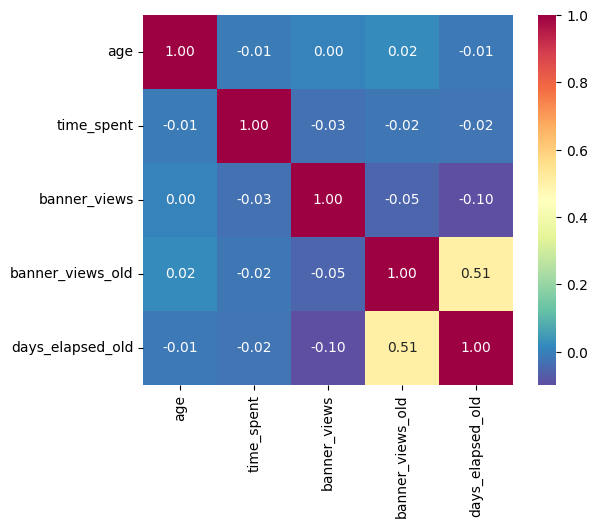

In [9]:
corrmat = numerical_columns.corr(numeric_only=True)
hm = sns.heatmap(corrmat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels= numerical_columns_names, 
                 xticklabels=numerical_columns_names, 
                 cmap="Spectral_r")
plt.show()

One higher correlation between banner_views_old and days_elapsed_old -> maybe we need to do something with it

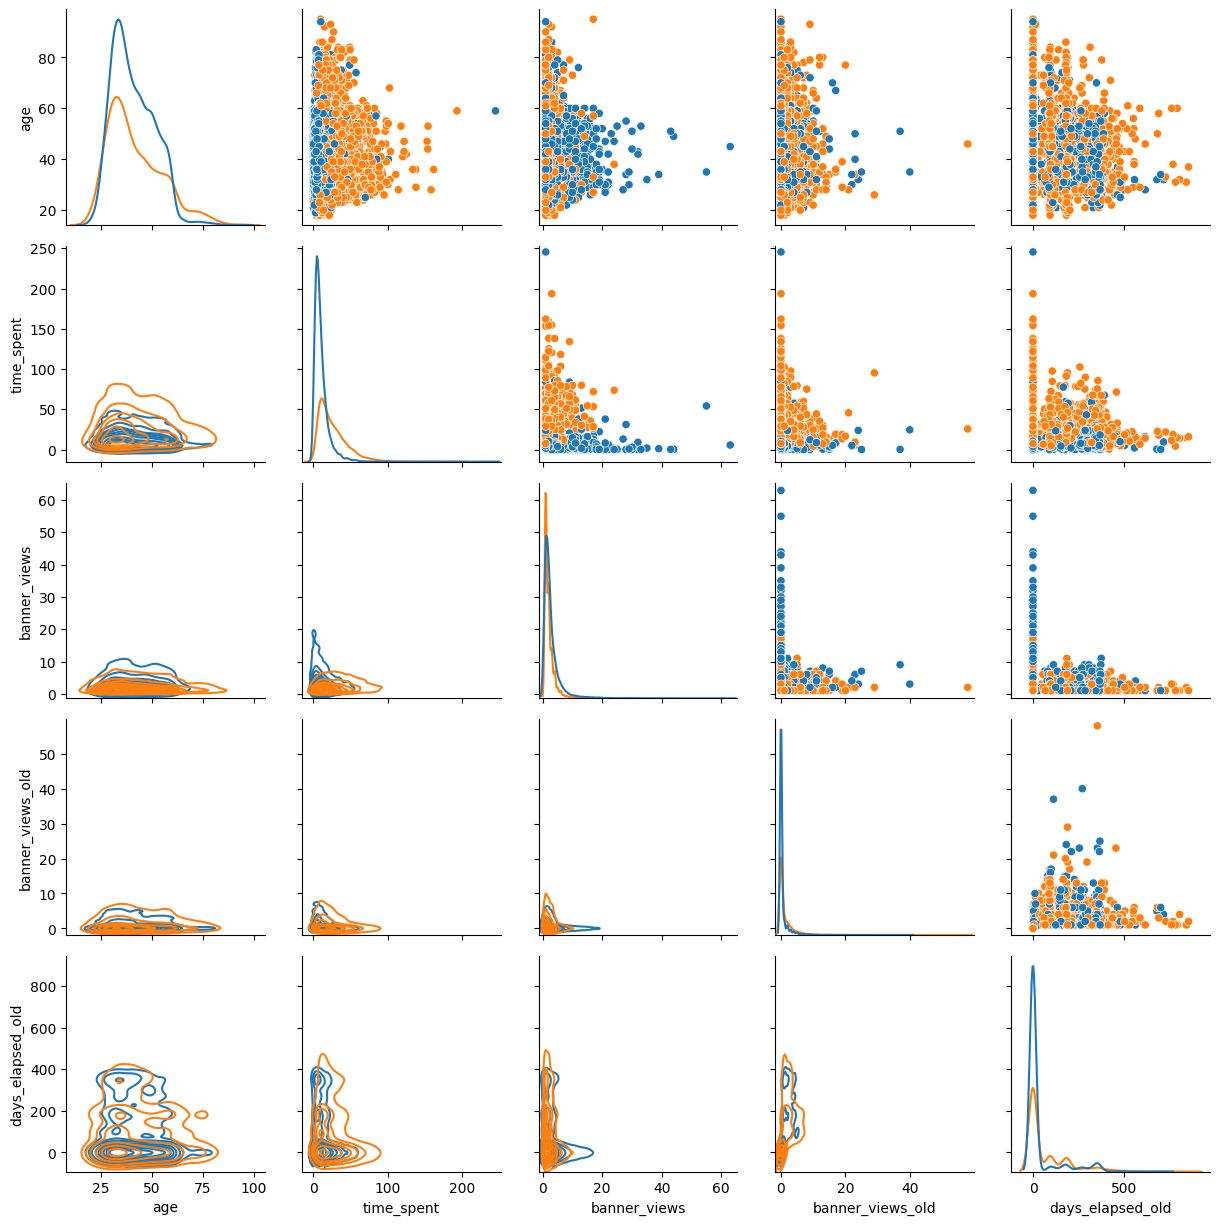

In [10]:
# sns.pairplot(numerical_columns_and_subscription, hue = 'subscription', diag_kind='kde')
g = sns.PairGrid(numerical_columns_and_subscription, diag_sharey=False, hue='subscription')
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)

Numerical columns not easily seperable. We probably need to do some feature engineering. Squaring / Logging / combining variables

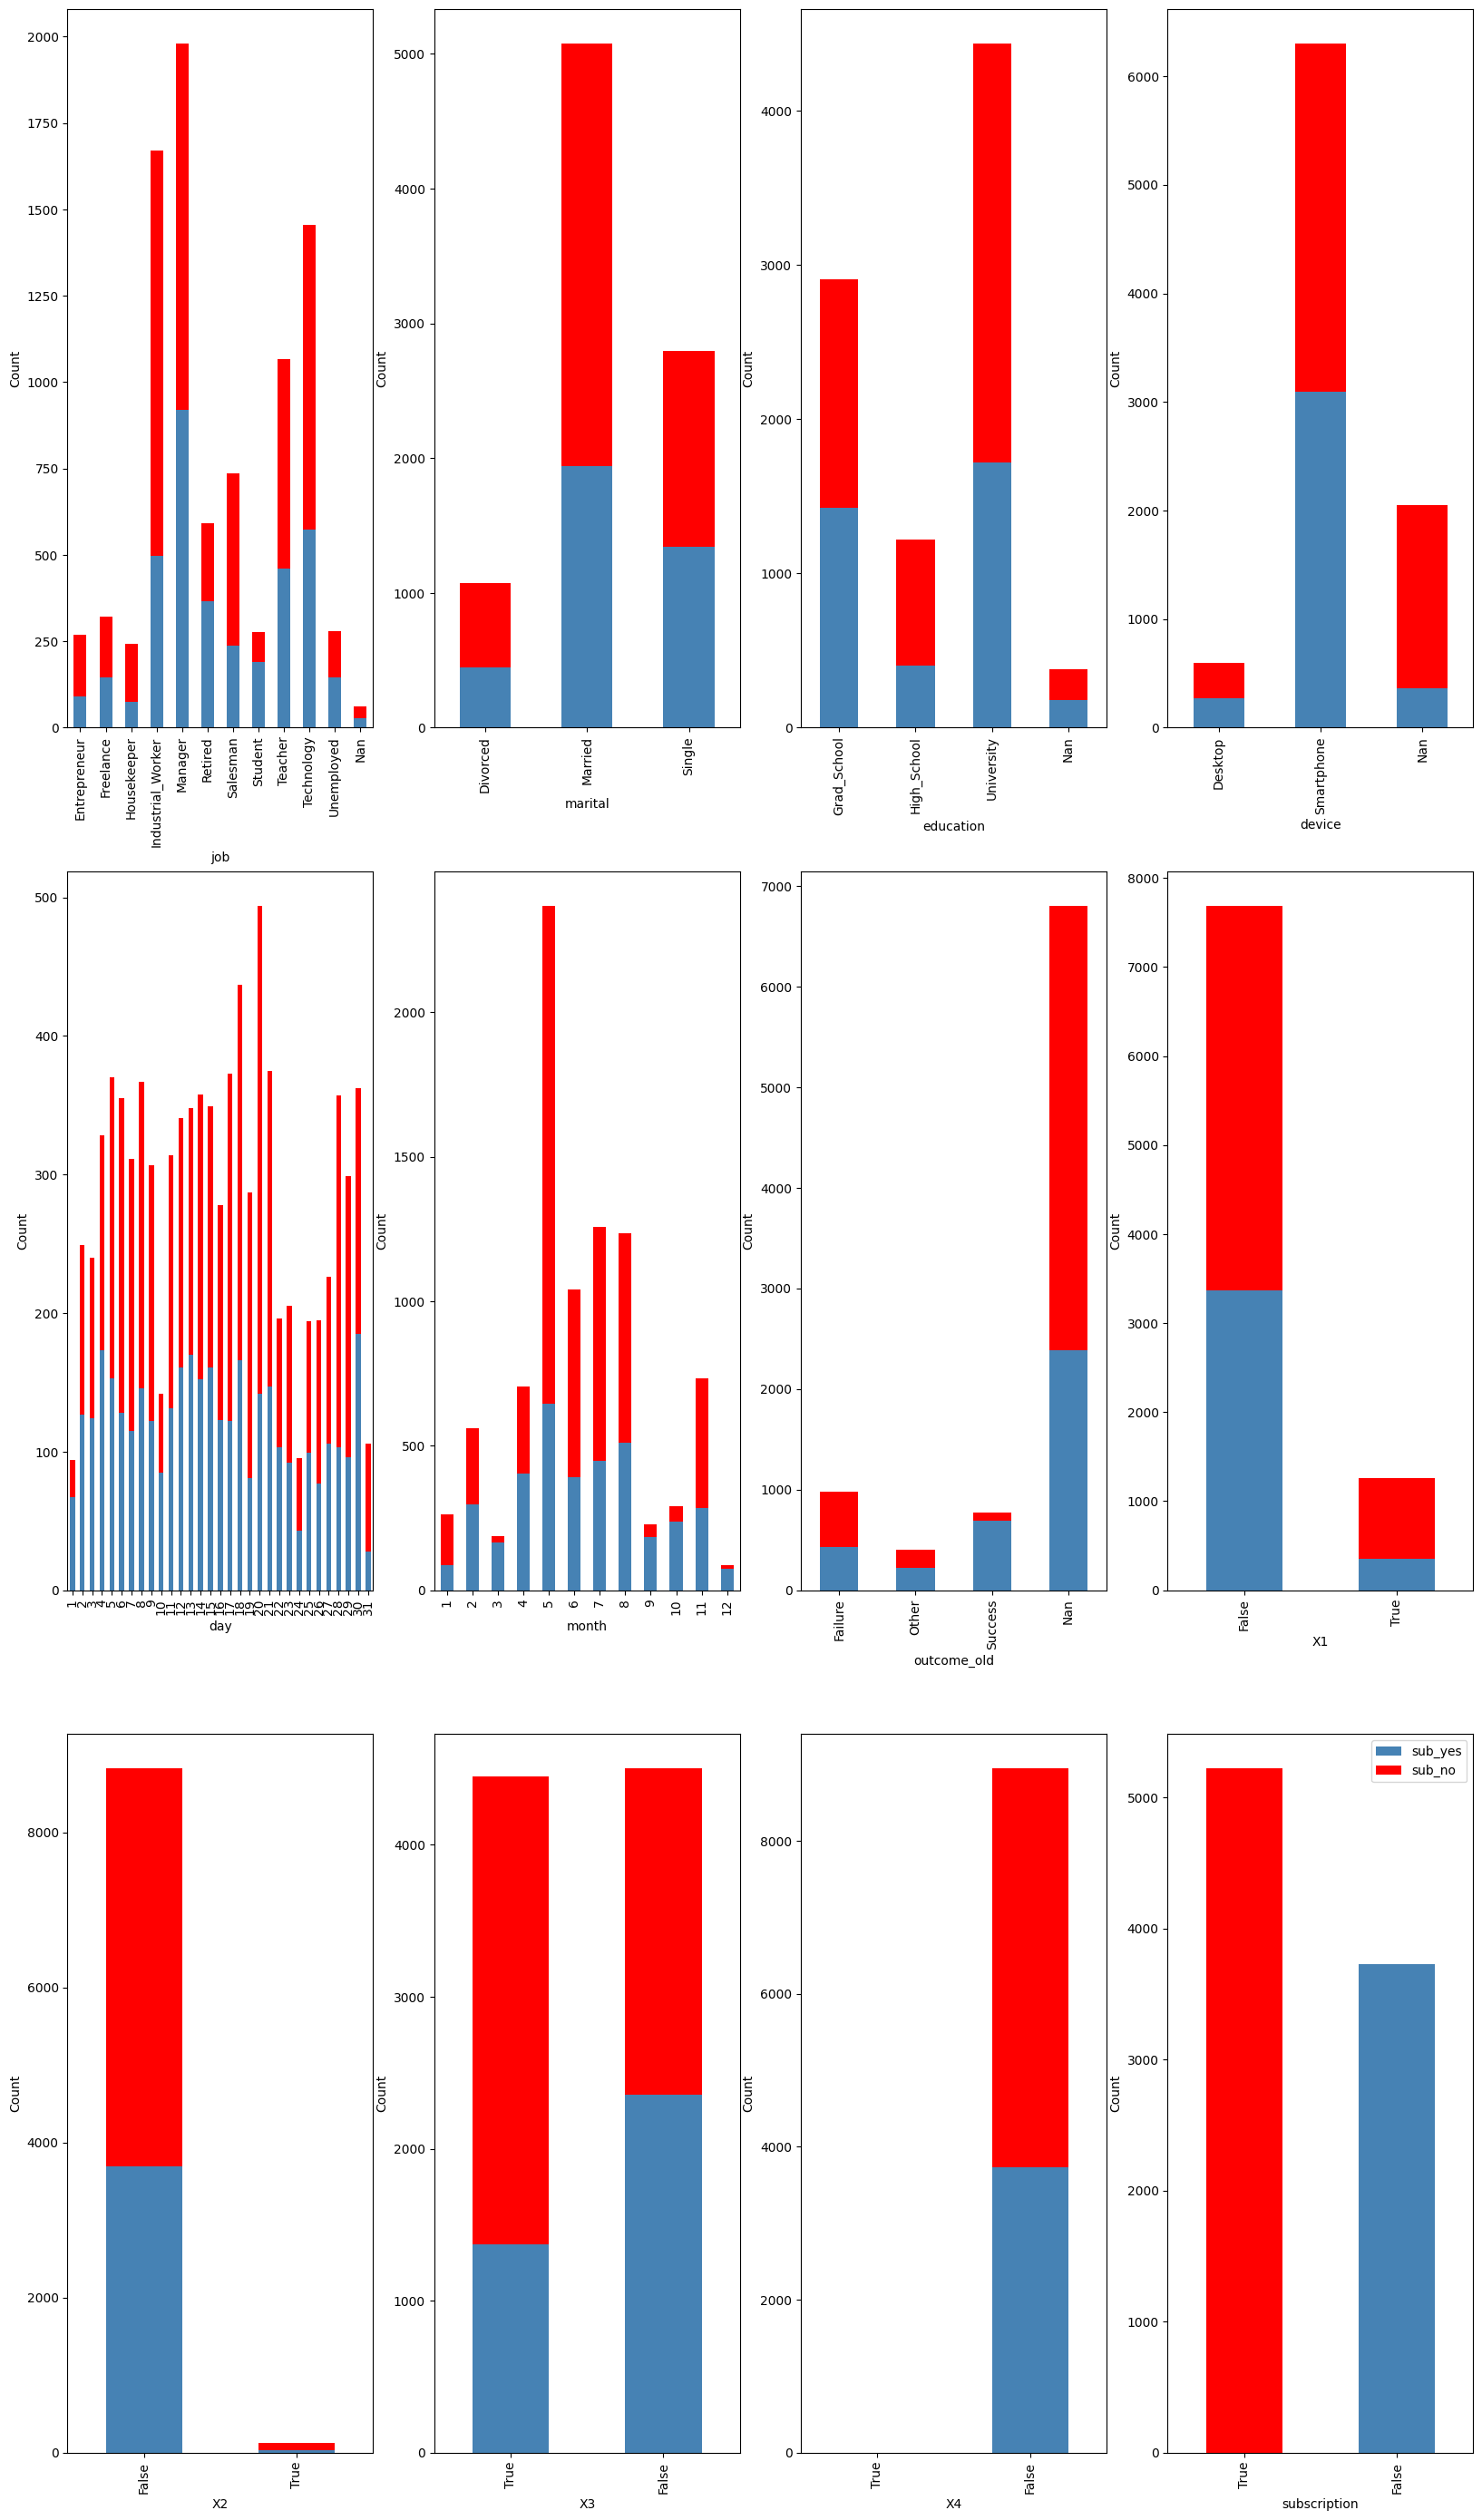

In [11]:
plt.figure(figsize=(20,35))
for i, col in enumerate(categorical_columns_names):
    ax = plt.subplot(3, 4, i+1)
    unique_values = [str(s).title() for s in categorical_columns[col].value_counts(dropna=False, sort=False).index]
    sub_yes = categorical_columns[col][categorical_columns.subscription == True].value_counts(dropna=False, sort=False)
    sub_no = categorical_columns[col][categorical_columns.subscription == False].value_counts(dropna=False, sort=False)
    temp = pd.DataFrame({'unique':unique_values,
                         'sub_yes':sub_yes,
                         'sub_no':sub_no})
    temp.plot(kind='bar', stacked=True, color=['steelblue', 'red'], ax=ax, legend = None)
    plt.xticks(range(len(unique_values)), unique_values, rotation=90)
    plt.xlabel(col)
    plt.ylabel('Count')

plt.legend()
plt.show()

We have NA's in the variables job, education, device, outcome_old. The other categorical variables do not have NA values. As these are all categorical variables it doesn't matter too much though as we can set NA values as a category of itself and work with it. Additionally there is one variable X4 which has almost only one outcome except for one row. We can scrap it as it doesn't provide no more information. What can be said more is that we also see that there is not one variable that splits the data easily. Maybe also scrap X2

## FE

/var/folders/j0/m71dtf9j0rvddgqlps9swgxc0000gn/T/ipykernel_52286/2717160682.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train.loc[:, ['month', 'day']] = train.loc[:,['month', 'day']].astype(dtype='str')


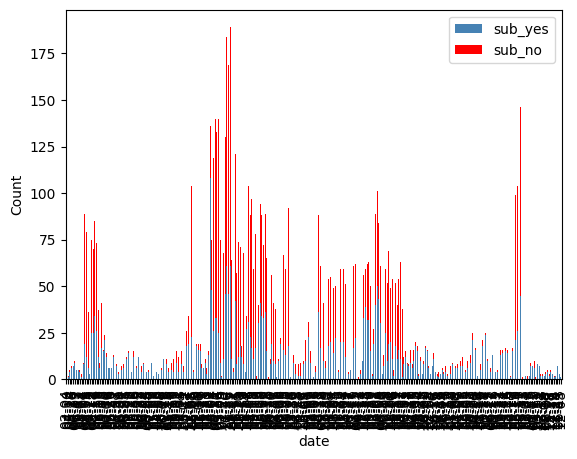

In [32]:
train.loc[:, ['month', 'day']] = train.loc[:,['month', 'day']].astype(dtype='str')
train['date'] = pd.to_datetime('2023-' + train['month'] + "-" + train['day'])
train['date'] = train['date'].dt.strftime('%m-%d')
categorical_columns['date'] = train['date']
col='date'
unique_values = [str(s).title() for s in categorical_columns[col].value_counts(dropna=False, sort=False).index]
sub_yes = categorical_columns[col][categorical_columns.subscription == True].value_counts(dropna=False, sort=False)
sub_no = categorical_columns[col][categorical_columns.subscription == False].value_counts(dropna=False, sort=False)
temp = pd.DataFrame({'unique':unique_values,
                        'sub_yes':sub_yes,
                        'sub_no':sub_no})
temp.plot(kind='bar', stacked=True, color=['steelblue', 'red'], legend = None)
plt.xticks(range(len(unique_values)), unique_values, rotation=90)
plt.xlabel(col)
plt.ylabel('Count')
plt.legend()
del(train['date'], categorical_columns['date'])

There are date where more subscriptions were obtained and some where the denial was higher. Probably when a newsletter or something was sent out. 

In [33]:
train = train.loc[:, train.columns!='X4']
train.loc[:,['X1','X2','X3', 'subscription']] = train.loc[:,['X1','X2','X3', 'subscription']].astype(dtype='int64')
train = pd.get_dummies(train, dummy_na=True)
n_sqd = numerical_columns**2
n_sqd = n_sqd.add_suffix('_sqd')
n_log = np.log(numerical_columns+1)
n_log = n_log.add_suffix('_log')
n_div = 1/(numerical_columns+1)
n_div = n_div.add_suffix('_div')
trraaaain = pd.concat([train, n_sqd, n_log, n_div])

test = pd.get_dummies(test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [34]:
trraaaain

,age,time_spent,banner_views,banner_views_old,days_elapsed_old,X1,X2,X3,subscription,job_entrepreneur,...,age_log,time_spent_log,banner_views_log,banner_views_old_log,days_elapsed_old_log,age_div,time_spent_div,banner_views_div,banner_views_old_div,days_elapsed_old_div
Id,,,,,,,,,,,,,,,,,,,,,
0,28.0,26.80,3.0,4.0,196.0,0.0,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,48.0,13.05,1.0,1.0,79.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27.0,8.10,3.0,0.0,-1.0,0.0,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44.0,7.10,2.0,1.0,369.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29.0,15.90,2.0,2.0,143.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.018182,0.120482,0.500000,1.0,inf
8948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.022727,0.025806,0.333333,1.0,inf
8949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.035714,0.033333,0.250000,1.0,inf


# Predictive model

## Logistic Regression

Logistic regression, Lasso, and Ridge are three popular statistical techniques used in regression analysis. Here's a brief explanation of each:

1. Logistic regression is a type of regression analysis used to model the probability of a binary response variable. It is commonly used in machine learning applications where the goal is to predict a binary outcome, such as whether a customer will buy a product or not. The logistic regression model estimates the relationship between a set of independent variables and a binary dependent variable by calculating the probability of the event occurring.

2. Lasso, short for "Least Absolute Shrinkage and Selection Operator," is a regularization technique used in regression analysis to prevent overfitting. It works by adding a penalty term to the regression equation that shrinks the coefficients of less important features to zero, effectively selecting only the most important features in the model. Lasso is useful when working with high-dimensional data, where there are many features but only a subset of them are relevant for the prediction task.

3. Ridge regression is another regularization technique used in regression analysis to prevent overfitting. Like Lasso, it adds a penalty term to the regression equation, but instead of shrinking the coefficients to zero, it shrinks them towards zero. This helps to reduce the impact of multicollinearity, where two or more predictor variables are highly correlated, which can cause the regression coefficients to become unstable. Ridge is useful when working with data that has a high degree of multicollinearity.

We will only use Ridge and Lasso model for Predictive purposes in this analysis


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler

# Import Data

#Scale features
scaler = StandardScaler()
train_logistic = scaler.fit_transform(train_logistic)
test_logistic = scaler.transform(test_logistic)

### Logistic

In [ ]:
#Model
lr = LinearRegression()

#Fit model
lr.fit(X_train, y_train)

#predict
#prediction = lr.predict(X_test)

#actual
actual = y_test

train_score_lr = lr.score(X_train, y_train)
test_score_lr = lr.score(X_test, y_test)

print("The train score for lr model is {}".format(train_score_lr))
print("The test score for lr model is {}".format(test_score_lr))

### Ridge

In [ ]:
#Ridge Regression Model
ridgeReg = Ridge(alpha=10)

ridgeReg.fit(X_train,y_train)

#train and test scorefor ridge regression
train_score_ridge = ridgeReg.score(X_train, y_train)
test_score_ridge = ridgeReg.score(X_test, y_test)

print("\nRidge Model............................................\n")
print("The train score for ridge model is {}".format(train_score_ridge))
print("The test score for ridge model is {}".format(test_score_ridge))

### Lasso


In [ ]:
#Lasso regression model
print("\nLasso Model............................................\n")
lasso = Lasso(alpha = 10)
lasso.fit(X_train,y_train)
train_score_ls =lasso.score(X_train,y_train)
test_score_ls =lasso.score(X_test,y_test)

print("The train score for ls model is {}".format(train_score_ls))
print("The test score for ls model is {}".format(test_score_ls))


## Description of best model

## Comparison with other models

## Tuning parameter analysis

## Model selection approach

# Diagnostics and kaggle prediction

## Diagnostics

## Kaggle prediction

# Conclusion